In [4]:
import numpy as np
import matplotlib.pyplot as plt

from zsindy.dynamical_models import DynamicalSystem, lorenz
from zsindy.plotting import EvsZSindyPlotter 
from zsindy.ml_module import ZSindy

import pysindy as ps
from tqdm import tqdm 


In [5]:

# E-Sindy
threshold = 0.01
e_ensemble_trials = 10
bagging = True
poly_degree = 2

# Zsindy parameters
z_ensemble_trials = e_ensemble_trials
rho = 0.1
zsindy_num_terms = 4 
lmbda = 1e5

# Noise
eta = 0.05

## Simulate dynamical system
x0 = (0, 1, 1.05)
tend = 20
dt = 0.005
args = (10, 28, 8/3)


In [6]:
dyn = DynamicalSystem(lorenz, poly_degree, args, num_variables=len(x0))
X = dyn.solve(x0, dt, tend)
true_coefs = dyn.true_coefficients
varnames = dyn.varnames
lambda_norm = dyn.time/dt * rho**2

true_feats = ['x, y', 'x, y, x z', 'z, x y'] # Generate those in DynamicalSystem class (NOT USED HERE)
num_dims = X.shape[1]

# Add Noise
X += eta * np.random.randn(*X.shape)

In [7]:
## Z-Sindy
zmodel = ZSindy(rho=rho, 
                lmbda=lmbda, 
                max_num_terms=zsindy_num_terms, 
                poly_degree=poly_degree,
                variable_names=varnames)

zmodel.fit(X, dyn.time)

print("\nZ-Sindy Model:")
zmodel.print()
z_x_pred = zmodel.simulate(x0, dyn.time)
z_xdot_pred = zmodel.predict()


# E-SINDy
poly_library = ps.PolynomialLibrary(degree=poly_degree)
opt = ps.STLSQ(threshold=threshold)
ensembleopt = ps.optimizers.EnsembleOptimizer(opt, bagging=bagging, n_models=e_ensemble_trials)
model = ps.SINDy(feature_library=poly_library,
                 optimizer=ensembleopt, 
                 feature_names=varnames)

model.fit(X, t=dyn.time)

print("\nE-Sindy Model:")
model.print()

Theta = model.feature_library.transform(X)
xdot = model.differentiate(X, t=dyn.time)

feat_names = poly_library.get_feature_names(varnames)
num_feats = Theta.shape[1]

sindy_coefs = model.coefficients()
e_xdot_pred = model.predict(X)
e_x_pred = model.simulate(X[0], t=dyn.time)


Z-Sindy Model:
( x )' =  + -9.9938 x + 9.9933 y
( y )' =  + 27.9243 x + -0.9869 y + -0.9978 x*z
( z )' =  + -2.6646 z + 0.9993 x*y

E-Sindy Model:
(x)' = -0.003 1 + -9.994 x + 9.993 y
(y)' = -0.005 1 + 27.901 x + -0.981 y + -0.002 z + -0.997 x z
(z)' = -0.115 1 + 0.002 x + -0.005 y + -2.661 z + 0.999 x y


In [8]:


print('\nNumber of features: ', num_feats)
print('Feature names :', feat_names)
print('Feature matrix shape: ', Theta.shape)
print('x_dot shape: ', xdot.shape)

print('\nZSindy x Error:', np.linalg.norm(X - z_x_pred, 2))
print('ESindy x Error:', np.linalg.norm(X - e_x_pred, 2))
print('ZSindy xdot Error:', np.linalg.norm(xdot - z_xdot_pred, 2))
print('ESindy xdot Error:', np.linalg.norm(xdot - e_xdot_pred, 2))



Number of features:  10
Feature names : ['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']
Feature matrix shape:  (4000, 10)
x_dot shape:  (4000, 3)

ZSindy x Error: 485.2708113079371
ESindy x Error: 593.3611507732224
ZSindy xdot Error: 457.8306406568578
ESindy xdot Error: 457.82581493749115


In [9]:


# Predictions for zsindy
e_ensemble_coefs = np.array(model.optimizer.coef_list)
e_mean_coefs = np.mean(e_ensemble_coefs, axis=0)
e_std_coefs = np.std(e_ensemble_coefs, axis=0)

X_pred = model.simulate(X[0], t=dyn.time)

z_coef_error = np.sqrt((zmodel.coefficients() - true_coefs)**2)
e_coef_error = np.sqrt((model.coefficients() - true_coefs)**2)

z_std_coefs = np.sqrt(zmodel.coefficients_variance())
z_mean_coefs = zmodel.coefficients()

# scaled stds for comparison
non_zero_scales = []
for i in range(z_std_coefs.shape[0]): 
    for j in range(z_std_coefs.shape[1]):
        if z_std_coefs[i, j] != 0 and e_std_coefs[i, j] != 0:
            non_zero_scales.append(e_std_coefs[i, j]/z_std_coefs[i, j])

z_scale = np.mean(non_zero_scales)


# # Simulate e-sindy and z-sindy models by sample coefficients from distribution of coefficients and running them for a number of time steps
e_ensemble_coefs = np.array(model.optimizer.coef_list)

e_xdot_ensemble = np.zeros((e_ensemble_trials, len(dyn.time), num_dims))
e_xpred_ensemble = np.zeros((e_ensemble_trials, len(dyn.time), num_dims))


In [10]:

print(f"\nSimulating ensemble of {e_ensemble_trials} E-Sindy models...")
for i in tqdm(range(e_ensemble_trials)):
    model.coefficients()[: , :] = e_ensemble_coefs[i, :, :]

    e_xdot = model.predict(X)
    e_xpred = model.simulate(X[0], t=dyn.time)

    e_xdot_ensemble[i, :, :] = e_xdot
    e_xpred_ensemble[i, :, :] = e_xpred


# Generate coefficients from distribution
z_coef_ensemble = np.zeros((z_ensemble_trials, num_dims, num_feats))
z_scaled_std = z_scale*z_std_coefs

for i in tqdm(range(z_ensemble_trials)):
    for j in range(num_dims):
        z_coef_ensemble[i, j, :] = np.random.normal(zmodel.coefficients()[j, :], z_scaled_std[j])

# Simulate models
z_xdot_pred_ensemble = np.zeros((z_ensemble_trials, len(dyn.time), num_dims))
z_xpred_ensemble = np.zeros((z_ensemble_trials, len(dyn.time), num_dims))

print(f"\nSimulating ensemble of {z_ensemble_trials} Z-Sindy models...")
for i in tqdm(range(z_ensemble_trials)):
    z_xdot = Theta @ z_coef_ensemble[i, :, :].T
    z_xpred = zmodel.simulate(X[0], dyn.time, coefs=z_coef_ensemble[i, :, :])

    z_xdot_pred_ensemble[i, :, :] = z_xdot
    z_xpred_ensemble[i, :, :] = z_xpred



Simulating ensemble of 10 E-Sindy models...


100%|██████████| 10/10 [00:00<00:00, 28728.11it/s]



Simulating ensemble of 10 Z-Sindy models...


100%|██████████| 10/10 [00:00<00:00, 22.54it/s]


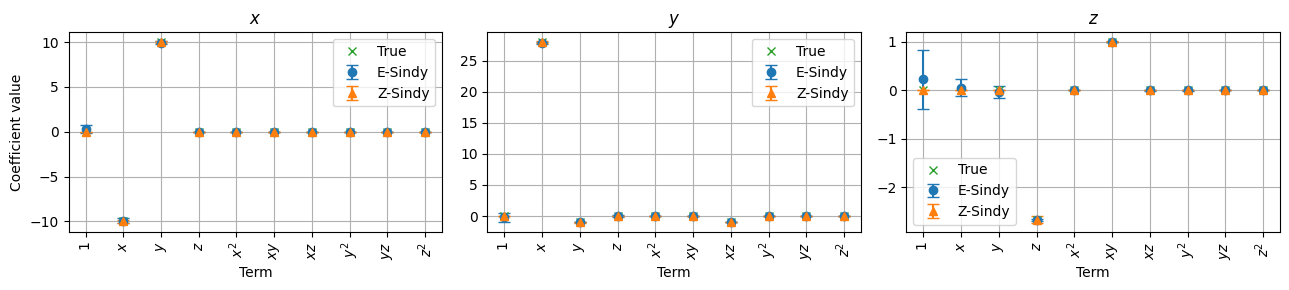

In [11]:

# Plotting 
plot = EvsZSindyPlotter(true_coefs, feat_names, varnames)

fig, axes = plot.e_vs_zsindy_coefs(e_mean_coefs, e_std_coefs, z_mean_coefs, z_std_coefs, z_scale)

plt.show()

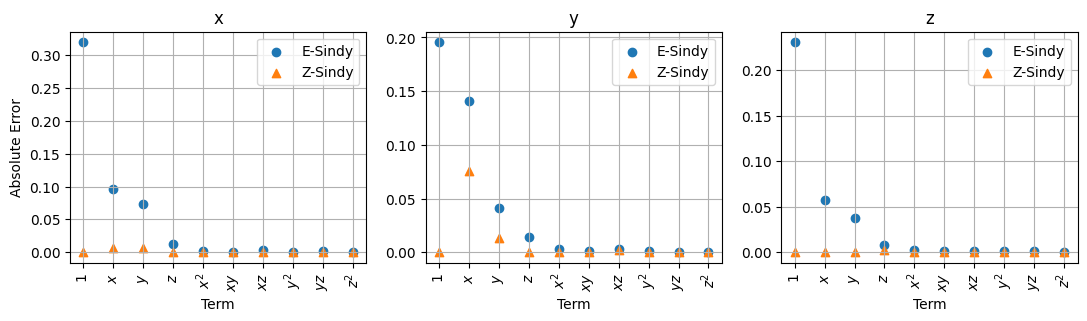

In [12]:
plot.e_vs_zsindy_coef_error(e_mean_coefs, zmodel.coefficients())


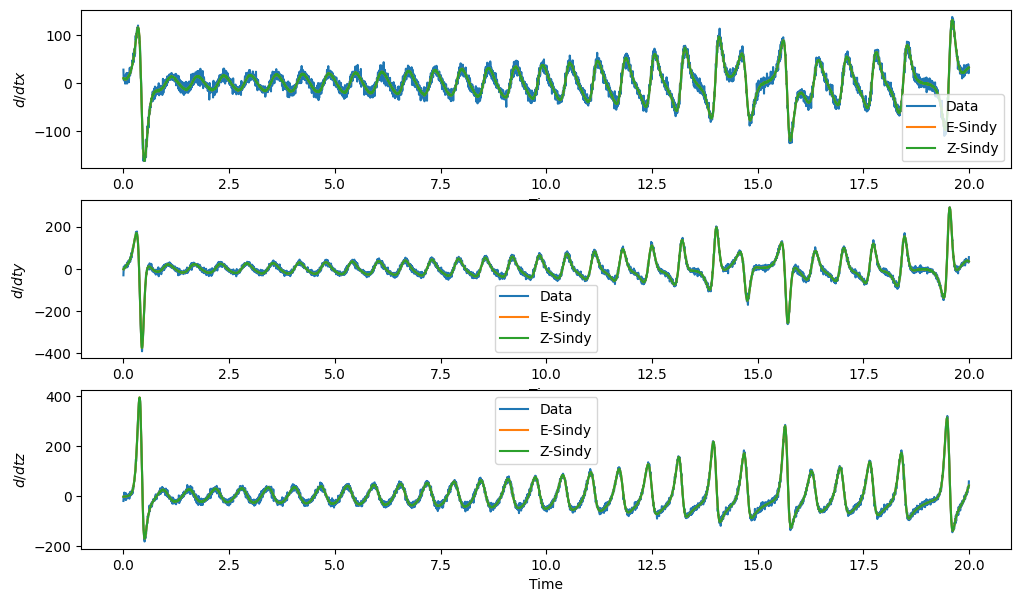

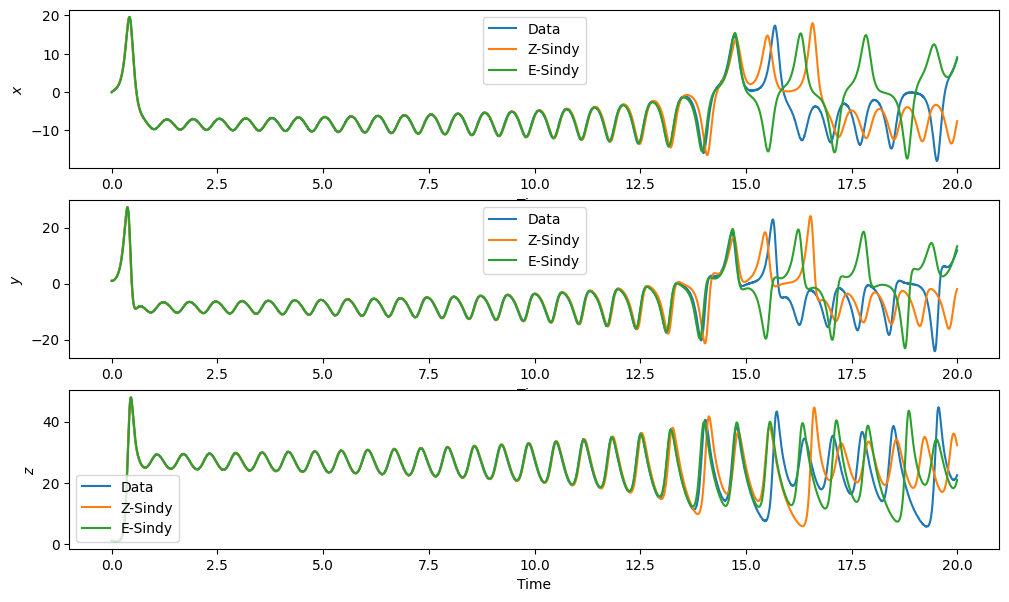

In [13]:
plot.e_vs_zsindy_simulations(xdot, X, e_xdot_pred, e_x_pred, z_xdot_pred, z_x_pred, dyn.time)



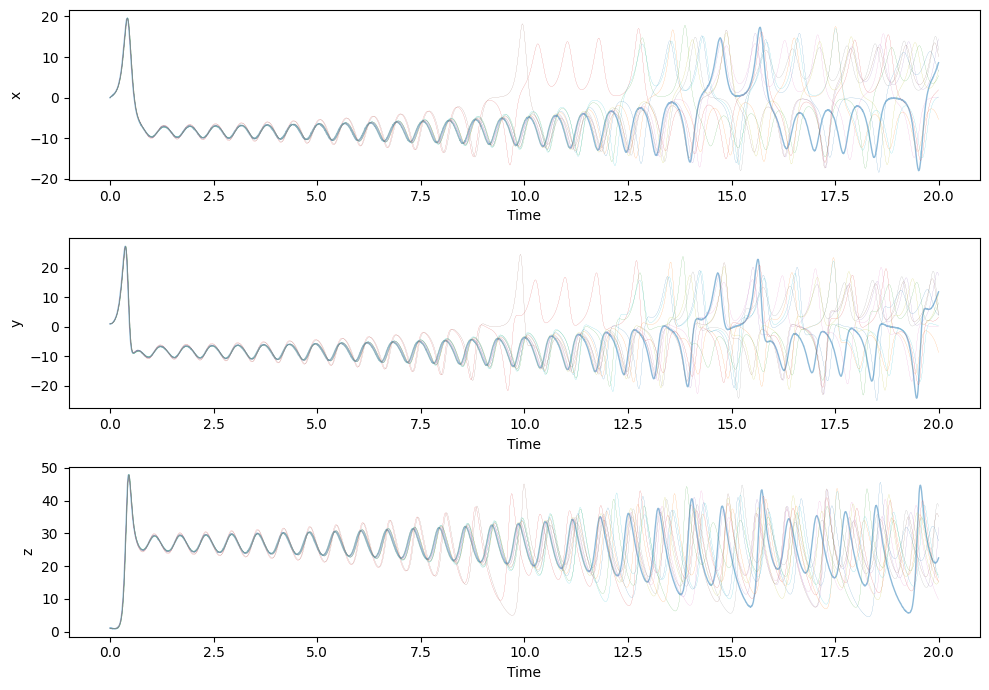

In [14]:
plot.e_sindy_alltrials(X, e_xpred_ensemble, dyn.time)


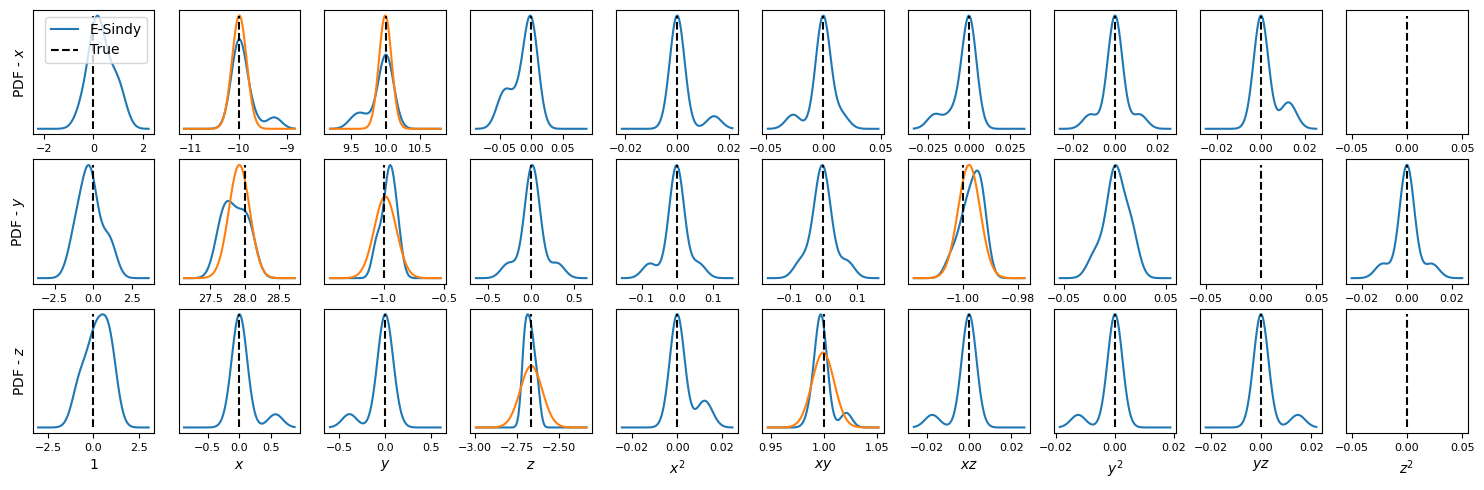

In [15]:
plot.e_vs_zsindy_coefficient_distributions(e_ensemble_coefs, z_mean_coefs, z_std_coefs, z_scale, dyn.varnames, feat_names)


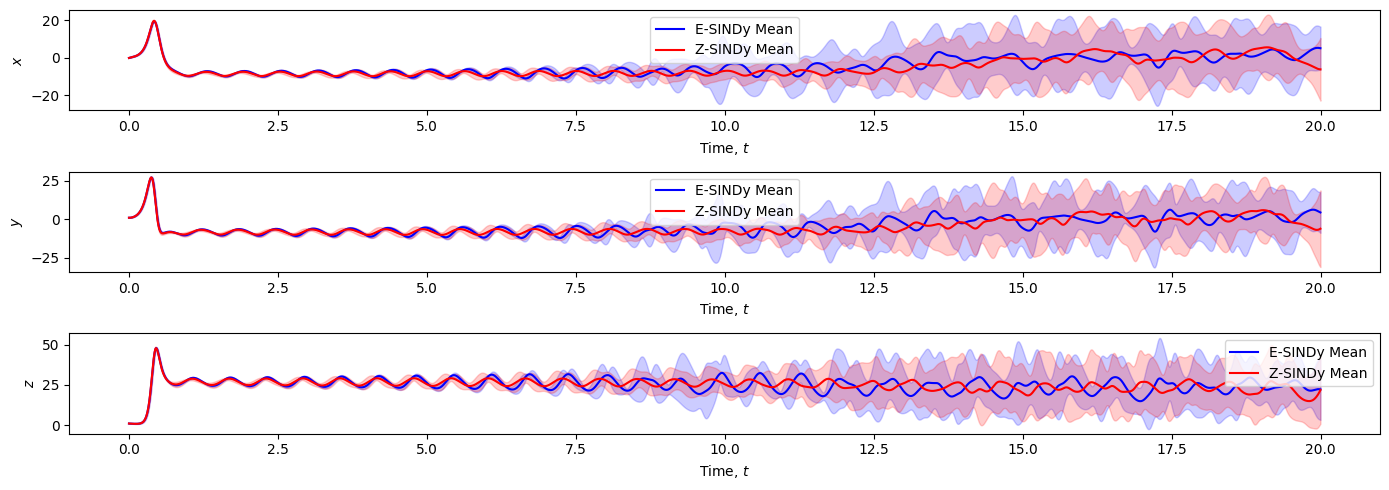

In [17]:
plot.e_vs_zsindy_simulation_envelopes(e_xpred_ensemble, z_xpred_ensemble, dyn.time, varnames)